# Define MHWs using Hobday definition

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import linregress
from xrft import detrend
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw

In [2]:
gpath = '/work5/stb/MHW-gfdl/Collab-LG_SS/cmems_mod_glo_phy_my_0.083deg_P1M-m_so-thetao_98.00W-80.00W_17.00N-31.00N_0.49-5727.92m_1993-01-01-2025-08-01.nc'
#esm4_path = '/work5/stb/ESM4/historical_1850-2014/ts/ocean_monthly_z.*.*.nc'
oisst_path = '/work5/stb/MHW-gfdl/Collab-LG_SS/OISST_gom_1981-2025_daily_sst.nc'
era_path = '/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ERA5/ds_era5.nc'

cora = xr.open_dataset('/work5/stb/MHW-gfdl/cora.nc', chunks={})
glorys_ds = xr.open_dataset(gpath, chunks={})
#ds_z = xr.open_mfdataset(esm4_path, chunks={}, decode_timedelta=True)
oisst_ds = xr.open_dataset(oisst_path)#, chunks={})
era = xr.open_dataset(era_path, chunks={})

|  | OISST | CORA | GLORYS | ERA5 |
| :---------- | :---------- | :----------: | ----------: | :---------- |
| Temperature | SST | 3D | 3D | SST |
| Sampling<br>frequency | Daily | Monthly | Monthly | Daily |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.1˚ x 0.5˚ | 1/12˚ x 1/12˚ | 0.25˚ x 0.25˚ |
|Time period | 1981-09 : 2025-09 | 1980-01 : 2024-06 | 1993-01 : 2025-08 | 1983-01 : 2021-06 |

In [3]:
oisst = oisst_ds.sst.sel(lon=slice(None, 279.625))

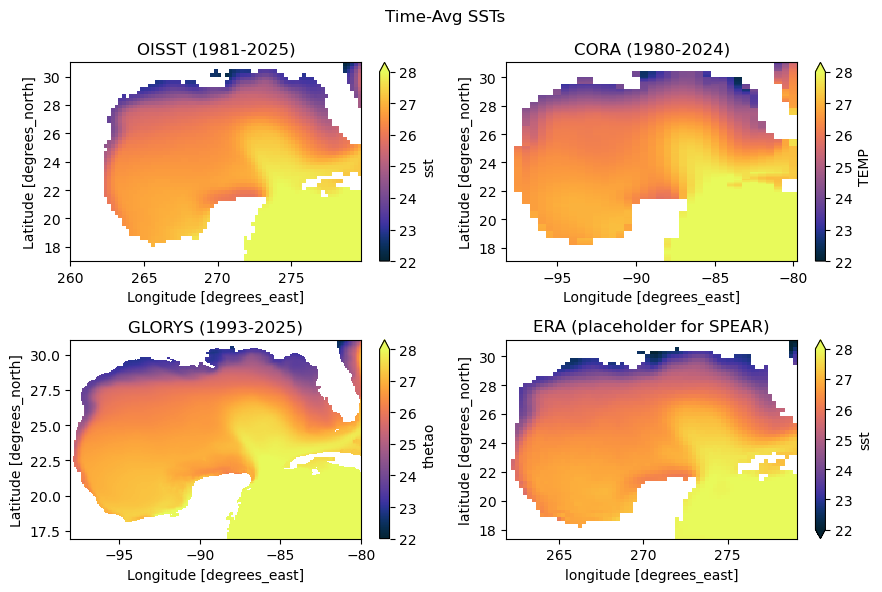

In [4]:
fig, ax = plt.subplots(2,2, figsize=(9,6))
oisst.mean('time').plot(ax=ax[0,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,0].set_title('OISST (1981-2025)')
cora.TEMP.isel(depth=0).mean('time').plot(ax=ax[0,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,1].set_title('CORA (1980-2024)')
glorys_ds.thetao.isel(depth=0).mean('time').plot(ax=ax[1,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,0].set_title('GLORYS (1993-2025)')
era.sst.mean('time').plot(ax=ax[1,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,1].set_title('ERA (placeholder for SPEAR)')
plt.suptitle('Time-Avg SSTs')
plt.tight_layout();

In [5]:
def trending_line(da, da_name, coord_name=None):
    
    d = {}
    d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean([da.dims[1], da.dims[2]]))
    d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])
    return d

In [6]:
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [7]:
trending_line(oisst, oisst.name)

{'sst_trend_lr': LinregressResult(slope=np.float64(6.911383219221096e-05), intercept=np.float64(25.931747054173016), rvalue=np.float64(0.13600566236439077), pvalue=np.float64(2.4735458968492945e-67), stderr=np.float64(3.967840722402652e-06), intercept_stderr=np.float64(0.03688299864184063)),
 'sst_trend_line_lr': array([25.93174705, 25.93181617, 25.93188528, ..., 27.04434152,
        27.04441064, 27.04447975])}

In [31]:
oisst.polyfit('time', deg=1)

<xarray.Dataset> Size: 71kB
Dimensions:               (degree: 2, lat: 56, lon: 79)
Coordinates:
  * degree                (degree) int64 16B 1 0
  * lat                   (lat) float32 224B 17.12 17.38 17.62 ... 30.62 30.88
  * lon                   (lon) float32 316B 260.1 260.4 260.6 ... 279.4 279.6
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 71kB nan nan ... 23.67 24.0

In [43]:
p = oisst.polyfit(dim='time', deg=1) #('degree', 'lat', 'lon'){:16101, :56, :79}

#what does polyval do that is different from `.polyfit()`?
fit = xr.polyval(oisst.time, p.polyfit_coefficients) #('time', 'lat','lon'){:16101, :56, :79}

detrended_time = oisst - fit #detrended da along time dim

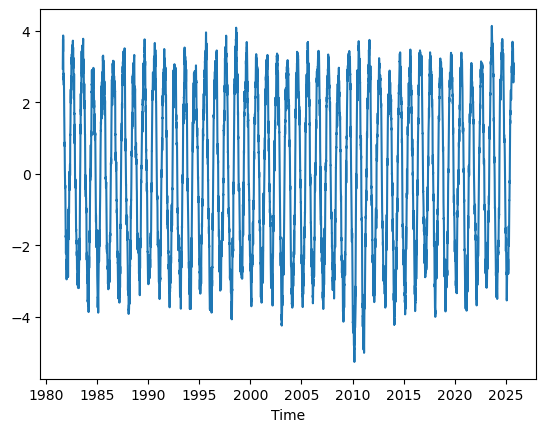

In [42]:
detrended_time.mean(['lat','lon']).plot()

In [44]:
anom = oisst.groupby('time.day') - oisst.groupby('time.day').mean('time') 

In [52]:
detrended_time

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ..., 0.56249045,
         0.61682021, 0.62065052],
        [       nan,        nan,        nan, ..., 0.73312377,
         0.75378651, 0.81314929],
        [       nan,        nan,        nan, ..., 0.8020876 ,
         0.85973364, 0.94598217],
        ...,
        [       nan,        nan,        nan, ..., 3.10062762,
         2.83790433, 2.88615597],
        [       nan,        nan,        nan, ..., 3.42294399,
         3.08692153, 2.91810974],
        [       nan,        nan,        nan, ..., 3.68840716,
         3.25868274, 2.97429929]],

       [[       nan,        nan,        nan, ..., 0.65242615,
         0.73675493, 0.86058641],
        [       nan,        nan,        nan, ..., 0.89305961,
         0.92372294, 0.98308597],
        [       nan,        nan,        nan, ..., 1.13202354,
         1.12967046, 1.13591725],
...
        [       nan,        nan,        nan, ..., 4.42173669,
         3.7155432 , 2.98889981],
        [       nan,        nan,        nan, ..., 4.68609461,
         3.9964043 , 3.25226161],
        [       nan,        nan,        nan, ..., 5.08845704,
         4.47995499, 3.77025527]],

       [[       nan,        nan,        nan, ..., 1.80490595,
         1.76289759, 1.67217779],
        [       nan,        nan,        nan, ..., 1.85251356,
         1.74903826, 1.60249053],
        [       nan,        nan,        nan, ..., 1.93180052,
         1.76505115, 1.56281654],
        ...,
        [       nan,        nan,        nan, ..., 4.40175307,
         3.78552349, 3.118842  ],
        [       nan,        nan,        nan, ..., 4.68612028,
         4.15639914, 3.512218  ],
        [       nan,        nan,        nan, ..., 5.07849843,
         4.62997146, 4.01023181]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88

In [51]:
anom.drop_vars('day') - detrended_time

<xarray.DataArray 'sst' (time: 16101, lat: 56, lon: 79)> Size: 285MB
array([[[       nan,        nan,        nan, ..., 0.03954697,
         0.09380722, 0.10094643],
        [       nan,        nan,        nan, ..., 0.21133041,
         0.2358017 , 0.29933167],
        [       nan,        nan,        nan, ..., 0.27808952,
         0.3392105 , 0.430624  ],
        ...,
        [       nan,        nan,        nan, ..., 3.2600212 ,
         2.6961498 , 2.4387207 ],
        [       nan,        nan,        nan, ..., 3.6564007 ,
         3.0687046 , 2.57864   ],
        [       nan,        nan,        nan, ..., 4.045994  ,
         3.4186783 , 2.8061218 ]],

       [[       nan,        nan,        nan, ..., 0.13495064,
         0.22132874, 0.3488388 ],
        [       nan,        nan,        nan, ..., 0.38150215,
         0.41576958, 0.47984123],
        [       nan,        nan,        nan, ..., 0.6186962 ,
         0.6200886 , 0.63090706],
...
        [       nan,        nan,        nan, ..., 3.96278   ,
         3.581419  , 3.194067  ],
        [       nan,        nan,        nan, ..., 4.146469  ,
         3.7380219 , 3.3426437 ],
        [       nan,        nan,        nan, ..., 4.402191  ,
         4.0278816 , 3.6770573 ]],

       [[       nan,        nan,        nan, ..., 2.236906  ,
         2.1924686 , 2.0956497 ],
        [       nan,        nan,        nan, ..., 2.2725925 ,
         2.168417  , 2.0215244 ],
        [       nan,        nan,        nan, ..., 2.3431854 ,
         2.177702  , 1.9797897 ],
        ...,
        [       nan,        nan,        nan, ..., 3.84227   ,
         3.567194  , 3.25169   ],
        [       nan,        nan,        nan, ..., 4.0280895 ,
         3.7991352 , 3.520399  ],
        [       nan,        nan,        nan, ..., 4.253292  ,
         4.0609264 , 3.8196926 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    day      (time) int64 129kB 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30

In [ ]:
detrended_time[500]

In [67]:
365+500

865

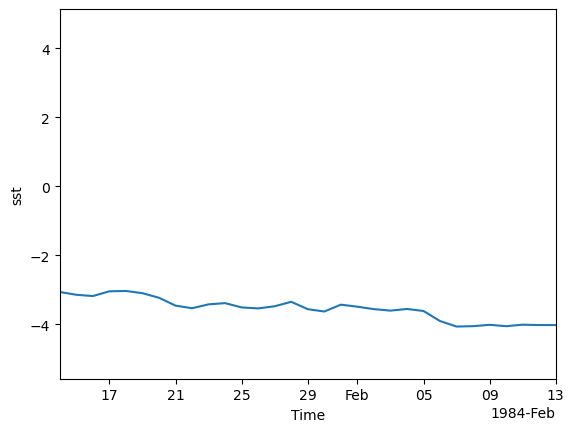

In [69]:
anom.mean(['lat','lon']).plot()
plt.xlim(anom.time[865], anom.time[895]);

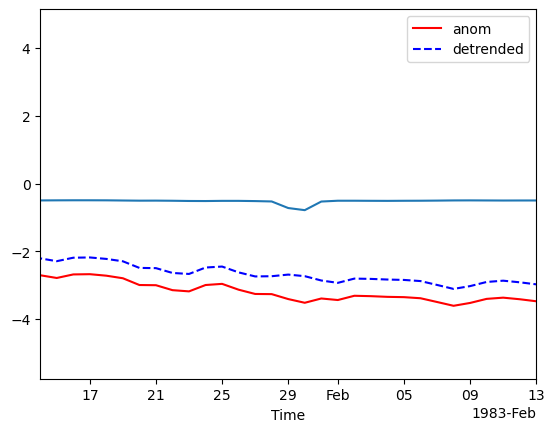

In [73]:
anom.mean(['lat','lon']).plot(label='anom', color='r')
detrended_time.mean(['lat','lon']).plot(label='detrended', linestyle='dashed', color='b')
(anom.drop_vars('day') - detrended_time).mean(['lat','lon']).plot() #so each Jan30-Feb1 step has a divet, why?
plt.xlim(detrended_time.time[500], detrended_time.time[530])
plt.legend();

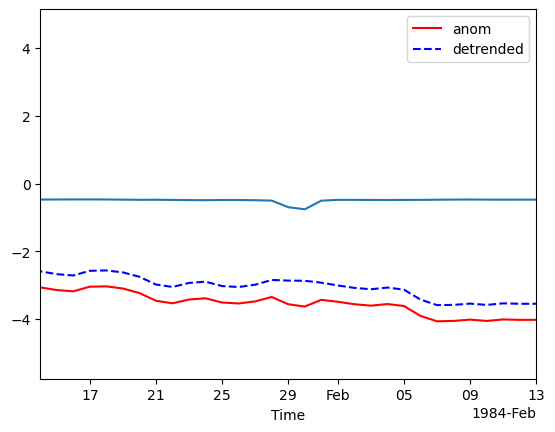

In [75]:
anom.mean(['lat','lon']).plot(label='anom', color='r')
detrended_time.mean(['lat','lon']).plot(label='detrended', linestyle='dashed', color='b')
(anom.drop_vars('day') - detrended_time).mean(['lat','lon']).plot() #so each Jan30-Feb1 step has a divet, why? maybe numberical question and not PO...
plt.xlim(detrended_time.time[865], detrended_time.time[895])
plt.legend();

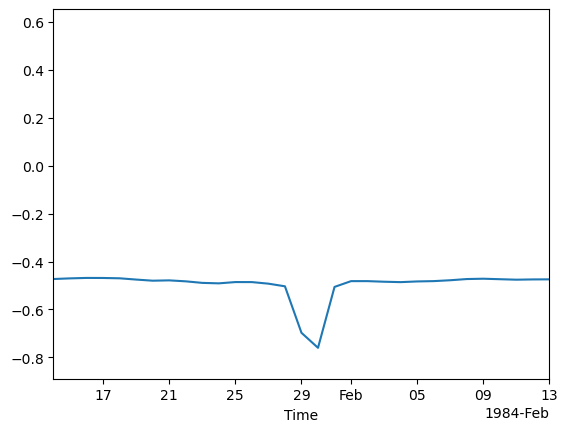

In [68]:
(anom.drop_vars('day') - detrended_time).mean(['lat','lon']).plot() #so each Jan30-Feb1 step has a divet, why?
plt.xlim(detrended_time.time[865], detrended_time.time[895]);

In [29]:
def detrend_dim(dim, da, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(dim, p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

In [18]:
fit = xr.polyval(oisst.time, trend_oisst.polyfit_coefficients)
detrended = (oisst-fit)

In [32]:
detrend_dim('time', oisst, deg=1)

AttributeError: 'str' object has no attribute 'dtype'

In [26]:
dims = oisst.dims
for dim in dims:
    da_detrended = detrend_dim(oisst, oisst[dim], deg=1)

TypeError: unhashable type: 'DataArray'

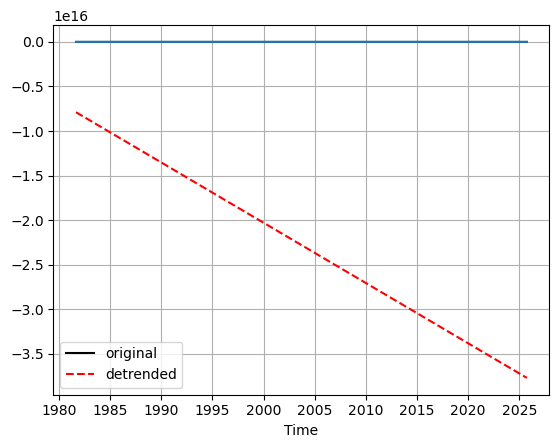

In [20]:
oisst.mean(['lat', 'lon']).plot(color='k', label='original')
plt.plot(oisst.time, trend_line)
detrended.mean(['lat', 'lon']).plot(label='detrended', linestyle='dashed', color='r')
#anom.mean(['lat', 'lon']).plot(color='cyan', linestyle='dotted', label='anom')
plt.grid()
plt.legend();

In [8]:
trend_line = trending_line(oisst, oisst.name)['sst_trend_line_lr']
trend_oisst = trending(oisst)
#repeat the array of each cell's trend slope to length of da's time dim to next detrend
trend_repeated = xr.concat([trend_oisst.polyfit_coefficients[0]] * len(oisst.time), dim='time')
detrended = oisst - trend_repeated

In [73]:
detrended = detrend(oisst.dropna, dim='time', detrend_type='linear')

AttributeError: 'function' object has no attribute 'data'

In [58]:
detrended

<xarray.DataArray 'sst' (time: 16101, lat: 56, lon: 79)> Size: 285MB
array([[[       nan,        nan,        nan, ..., 0.04369736,
         0.09985924, 0.10641479],
        [       nan,        nan,        nan, ..., 0.21781921,
         0.24141312, 0.3028202 ],
        [       nan,        nan,        nan, ..., 0.28694344,
         0.34739304, 0.43440056],
        ...,
        [       nan,        nan,        nan, ..., 3.2361908 ,
         2.681713  , 2.4274998 ],
        [       nan,        nan,        nan, ..., 3.6295319 ,
         3.0466614 , 2.5651627 ],
        [       nan,        nan,        nan, ..., 4.0234528 ,
         3.3943272 , 2.7872658 ]],

       [[       nan,        nan,        nan, ..., 0.13369751,
         0.21985817, 0.34641457],
        [       nan,        nan,        nan, ..., 0.37781906,
         0.4114132 , 0.47282028],
        [       nan,        nan,        nan, ..., 0.61694336,
         0.6173935 , 0.6243992 ],
...
        [       nan,        nan,        nan, ..., 4.286192  ,
         3.8717136 , 3.4475002 ],
        [       nan,        nan,        nan, ..., 4.4795322 ,
         4.036661  , 3.6051636 ],
        [       nan,        nan,        nan, ..., 4.753454  ,
         4.344328  , 3.9572659 ]],

       [[       nan,        nan,        nan, ..., 2.323698  ,
         2.2798576 , 2.1864147 ],
        [       nan,        nan,        nan, ..., 2.3678188 ,
         2.2614117 , 2.1128197 ],
        [       nan,        nan,        nan, ..., 2.4469433 ,
         2.2773933 , 2.0744    ],
        ...,
        [       nan,        nan,        nan, ..., 4.2661915 ,
         3.9417133 , 3.5774994 ],
        [       nan,        nan,        nan, ..., 4.4795322 ,
         4.196661  , 3.8651638 ],
        [       nan,        nan,        nan, ..., 4.743454  ,
         4.4943275 , 4.1972656 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88

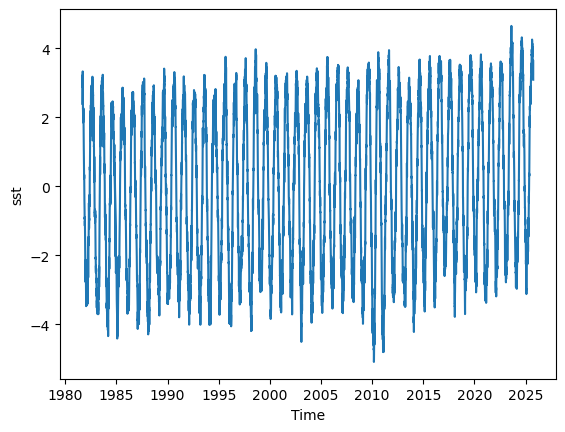

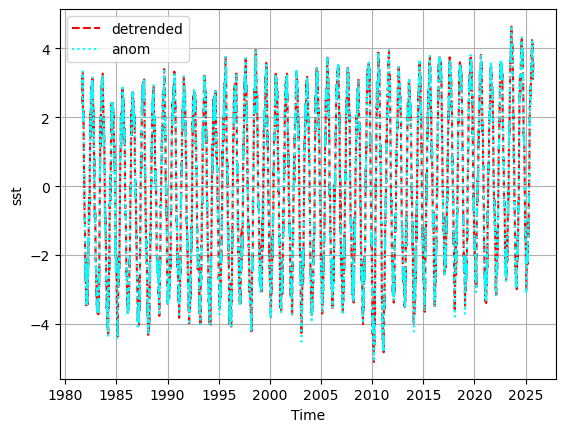

In [64]:
#oisst.mean(['lat', 'lon']).plot(color='k', label='original')
#plt.plot(oisst.time, trend_line)
detrended.mean(['lat', 'lon']).plot(label='detrended', linestyle='dashed', color='r')
anom.mean(['lat', 'lon']).plot(color='cyan', linestyle='dotted', label='anom')
plt.grid()
plt.legend();

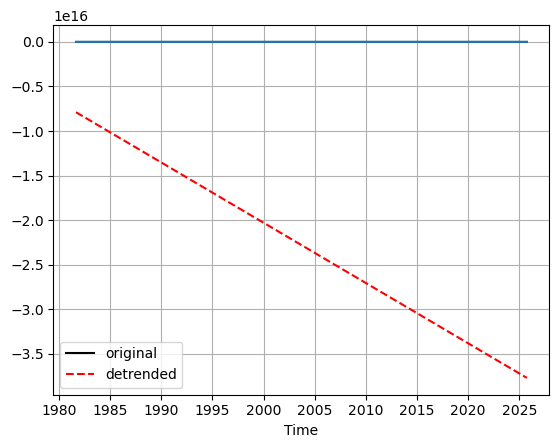

In [37]:
oisst.mean(['lat', 'lon']).plot(color='k', label='original')
plt.plot(oisst.time, trend_line)
detrended.mean(['lat', 'lon']).plot(label='detrended', linestyle='dashed', color='r')
plt.grid()
plt.legend();

In [29]:
(oisst-detrended).mean(['lat', 'lon'])

<xarray.DataArray (time: 16101)> Size: 129kB
array([0.02142761, 0.02142761, 0.02142761, ..., 0.02142761, 0.02142761,
       0.02142761])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
    degree   int64 8B 1

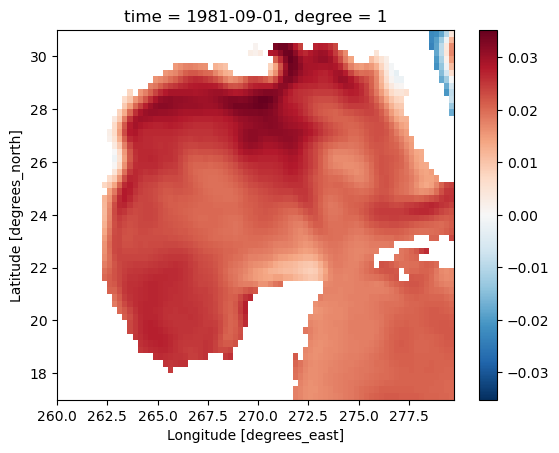

In [39]:
(oisst-detrended)[0].plot()

In [16]:
def seasons(da):
    DJF = da.where(da.time.dt.month.isin([12, 1, 2]))
    MAM = da.where(da.time.dt.month.isin([3, 4, 5]))
    JJA = da.where(da.time.dt.month.isin([6, 7, 8]))
    SON = da.where(da.time.dt.month.isin([9, 10, 11]))
    seasons_ds = xr.merge([DJF.rename('winter'), MAM.rename('spring'), 
                           JJA.rename('summer'), SON.rename('autmun')])
    return seasons_ds

In [19]:
seasons(oisst)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 16101, lon: 79, lat: 56)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
Data variables:
    winter   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    spring   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    summer   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    autmun   (time, lat, lon) float32 285MB nan nan nan ... 27.57 27.96 28.48
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

In [ ]:
clim = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear').mean('time')

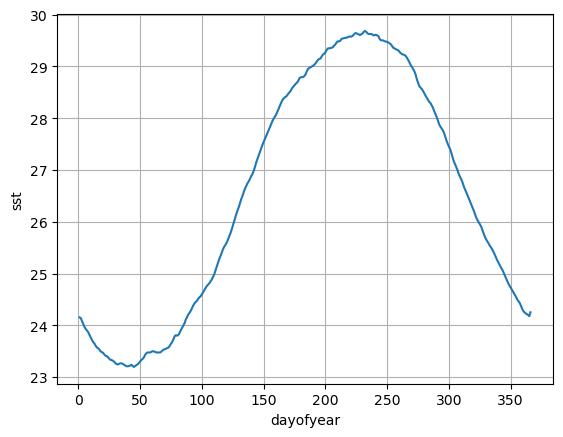

In [17]:
clim.mean(['lat','lon']).plot()
plt.grid()

In [35]:
#Group by day of the year and then calculate the 90th percentile
da = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear')
baseline_p90 = da.quantile(0.9, dim='time')

#reindex the baseline_p90 to match the full dataset's dayofyear
current_p90_threshold = baseline_p90.sel(dayofyear=oisst_ds.time.dt.dayofyear)

#Identify days where current temperature exceeds the 90th percentile baseline
exceedance_days = oisst_ds.sst.where(oisst_ds.sst > current_p90_threshold)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool = (oisst_ds.sst > current_p90_threshold)
#Make boolean mask int to count days for 5-day threshold
exceedance_int = exceedance_mask_bool.astype(int)
#Identify the events that are >=5 days
consecutive_exceedances = exceedance_int.rolling(time=5, center=False).sum()
long_exceedance_periods = consecutive_exceedances >= 5

# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances = exceedance_days.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

target_year_exceedances = exceedance_days.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :218,905
Number of days exceeding the 90th percentile in  2020: 299,701


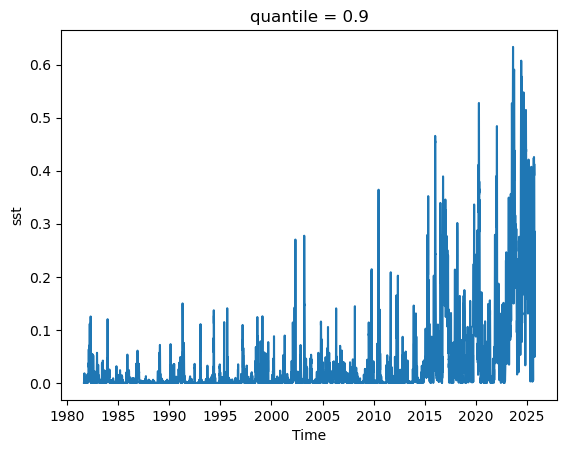

In [72]:
long_exceedance_periods.mean(['lat', 'lon']).plot()

In [69]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(exceedance_days.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(exceedance_days.sel(time=f'{year}').count())

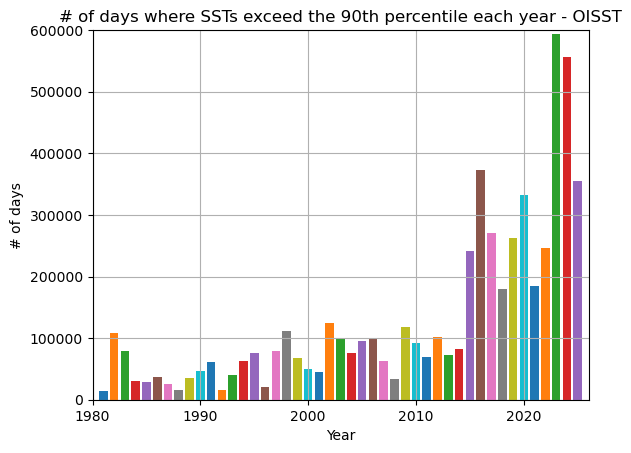

In [60]:
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
plt.ylim(0, 600000)
plt.xlim(1980, 2026)
plt.title('# of days where SSTs exceed the 90th percentile each year - OISST')
plt.grid();

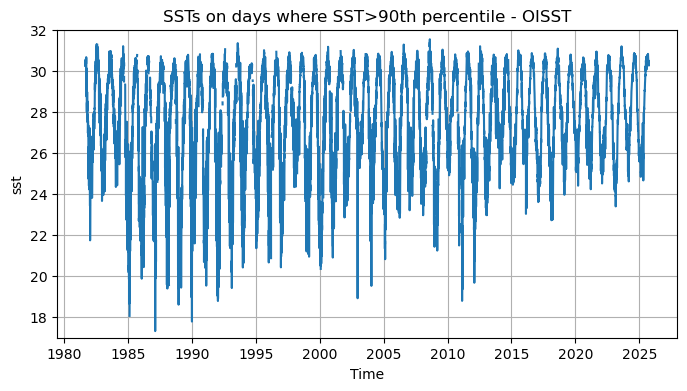

In [52]:
exceedance_days.mean(['lat', 'lon']).plot(figsize=(8,4))
plt.grid()
plt.ylim(17,32)
plt.title('SSTs on days where SST>90th percentile - OISST');